<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/ai4eo_logos.jpg' align='right' width='100%'/>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Adapted from worklows developed under the 2022 AI4EO MOOC**

<div class="alert alert-block alert-success">
<h3>Ocean colour applications</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- asdf

</div>
<hr>

# Using machine learning to combine Sentinel-2 and Sentinel-3 chlorophyll retrievals in coastal waters.

<i>by Ben Loveday (Innoflair/EUMETSAT), using tools developed by N. Pahlevan (NASA) and B. Smith (NASA)

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631907282?h=516cabbf13" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

*Note: This notebook has iterated since the making of this video, so you may notice a couple of small changes. This is mostly around data access.*

<hr>

## Introduction

<hr>

*Why are we doing this?*

When we want to monitor any environmental phenomena, one of the key things we must consider is how many measurements we need to make, and how often we need to make them. Satellites offer many advantages for environmental monitoring. Measurements can be made very often (usually in the order of multiple times per day to multiple times per week or month), and at increasingly high resolution and coverage (from 10's m in focused areas, through to 100's of m's and km scale globally). Because of instrument and satellite platform engineering, orbital requirements, data transfer, and physical limitations of measurement methods, there are nearly always compromises to be made in the spatial, temporal, and spectral/other resolutions and sensitivities in mission design. Thus, to optimise our monitoring approaches, we often need to use multiple data sources (different satellite, in situ or model datasets). 

The challenges of managing coastal and inland water quality as discussed in [the previous notebook](4G_CoastalWaterQuality_Classification.ipynb), are an example where the use of multiple data sources, can bring substantial benefits. However, combining data sources can be very difficult - the way that instruments measure, their sensitivities, and resolutions, have to be accounted for to create datasets that can be interpreted appropriately by decision makers.

<hr>

*What will this workflow show you?* 

This workflow will show you how to apply an *in situ* trained `mixture density network` to data from two Copernicus satellites to provide seamless chlorophyll-a concentrations from both satellites in a coastal region.

We will use data from two sources:
 * The [MSI](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) instrument aboard the Copernicus Sentinel-2 satellite
 * The [OLCI](https://www.eumetsat.int/ocean-colour-services) instrument aboard the Copernicus Sentinel-3 satellite

## Machine-Learning Algorithm

The workflow in this notebook uses [mixture density networks with Keras](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily). `Mixture density networks` (MDN) are a class of neural networks where the outputs of the network(s) are used in the parameterisation of Gaussians, giving a probability distribution over the target variable. This is particularly useful where you have non-unique inverse problems (such as is the case with ocean colour).

The MDN library we use was developed by NASA. We have added a subset of the MDN machine learning library here. The full model is available via;

 <b>*git clone https://github.com/STREAM-RS/MDN.git*</b>

The pre-trained model used in this example was generated using 1000 co-located in situ pairs of measurements of Chlorophyll-a concentration ([Chl-a]) and remote sensing reflectance (R$_{rs}$). For full details, see [Pahlevan et al., 2020](https://www.sciencedirect.com/science/article/pii/S0034425719306248)
 
 <hr>

*Note: You do not need to worry about this here, but in the future, if you wish to use this full model in a Jupyter Notebook environment, you must edit line 90 of parameters.py such that it says: cmdline=False*

*Note: For compatibility with the JupyterHub environment, this version of the model has been updated to use Tensorflow 2.x tf.keras in place of Tensorflow 2.x tensorflow.contrib.layers.python. We <b>highly recommend</b> that users use the full model, in its original state (link to GitHub above) for their further work.*

## Data

This workflow uses the following data:
* An [OLCI full resolution Level-2](https://www-cdn.eumetsat.int/files/2021-03/Sentinel-3%20OLCI%20Marine%20User%20Handbook.pdf) scene for the Baltic Sea at 09:11 on 20.04.2021 with standard atmospheric correction.
* An [MSI Level-2](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument) scene for the Baltic Sea at 10:00 on 20.04.2021 with standard atmospheric correction.
* In addition to the images above, we have also processed each scene from Level-1 using the [HYGEOS Polymer](https://www.hygeos.com/polymer) atmopsheric correction method.

## Further resources

The development of this module is explained comprehensively in the following references:

* ["Seamless retrievals of chlorophyll-a from Sentinel-2 (MSI) and Sentinel-3 (OLCI) in inland and coastal waters: A machine-learning approach". N. Pahlevan, et al. (2020). <i>Remote Sensing of Environment</i>. 111604. 10.1016/j.rse.2019.111604](https://www.sciencedirect.com/science/article/pii/S0034425719306248)

* ["Robust algorithm for estimating total suspended solids (TSS) in inland and nearshore coastal waters". S.V. Balasubramanian, et al. (2020). <i>Remote Sensing of Environment</i>. 111768. 10.1016/j.rse.2020.111768](https://www.sciencedirect.com/science/article/pii/S0034425719306248)

<hr>

## Notebook outline
* [1 - Comparing OLCI and MSI](#OLCI_MSI)
* [2 - Preparing our experiments](#exp_prep)
* [3 - Testing the MDN model](#model_test)
* [4 - Running the MDN model](#model_run)
* [5 - Comparing the MDN outputs](#outputs)
* [6 - Conclusions](#conclusions)

<hr>

#### Import libraries

In [2]:
import os # a library that gives us access to various command line tools to support pathing
import cartopy.crs as ccrs # a library that gives us access to cartopy's mapping capability
import cartopy.feature as cfeature # a library that extends cartopy to include features such as land masks
import glob # a library to allow us to discover files in our filesystem
import matplotlib # the basic python plotting library
from matplotlib import gridspec # a library that gives us better control over plot spacing
import matplotlib.pyplot as plt # the basic Python plotting library figure tools
import numpy as np # Python's array manipulation library 
import warnings # a library to manage warnings
import xarray as xr # a library to extend array management and add labelling
from scipy.interpolate import griddata # A 2D interpolation function
import requests # library for fetching data via HTTP
import zipfile # a library that helps us work with zip files
import io # a library that helps us translate data between fundamental formats
warnings.filterwarnings('ignore')

#### Fetching example data

Lets first fetch our mixed density network model and example data, then import it. This can take a little time.

In [3]:
urls = ["https://wekeo-files.apps.mercator.dpi.wekeo.eu/s/LEe9ALy7omEANRF/download/MDN.zip",
        "https://wekeo-files.apps.mercator.dpi.wekeo.eu/s/fbP388TW4yr4Ear/download/Support_data.zip"]
for url in urls:
    if not os.path.exists(os.path.basename(url).split('.')[0]):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(os.getcwd())

#### Defined functions

In [4]:
import support_functions as osf # an accompanying library of bespoke ML functions to support this notebook
from MDN import image_estimates, get_tile_data, get_sensor_bands # the mixed density network maching learning toolkit

<hr>

## 1 - Comparing Sentinel-3 OLCI and Sentinel-2 MSI <a id='OLCI_MSI'></a>

Sentinel-3 OLCI is the ocean colour workhorse of the Copernicus fleet. It was specifically designed to monitor the ocean and is regularly used in monitoring coastal systems. However, whilst nominally designed for land use, the high resolution of the Sentinel-2 MSI sensor also makes it a useful tool for monitoring the coasts. However, the two are quite different, and combing data from them is challenging. Lets look at the differences.

From Figure 1, we can see that the two sensors have markedly different spatial resolutions, with OLCI sampling at 300 m and MSI at 10/20/60 m, depending on the channel.

<table><tr>
<td> <img src="../../../img/S2_spatial_resolution.png" alt="Drawing" style="45%"/> </td>
<td> <img src="../../../img/S3_spatial_resolution.png" alt="Drawing" style="45%"/> </td>
</tr></table>

<center>Figure 1: A comparison of the spatial resolution of a 10 m Sentinel-2 view (left) and 300 m Sentinel-3 view (right) of a coccolithophore bloom off of the south west coast of the UK on June 23rd, 2020. Below we can see how these two sensors measure the spectra over the red box.</center>

From Figure 2, we can see that the two sensors have markedly different spectral characteristics. OLCI has many more bands in the visible region than MSI, and these bands are much more specific (e.g. narrower). OLCI also has a much better signal to noise ratio, meaning we can pull out much smaller signals from OLCI.

<table><tr>
<td> <img src="../../../img/S2_spectral_1200.png" alt="Drawing" style="45%"/> </td>
<td> <img src="../../../img/S3_spectral_1200.png" alt="Drawing" style="45%"/> </td>
</tr></table>

<center>Figure 2: A comparison of the spectral resolution Sentinel-2 MSI (left) and Sentinel-3 OLCI (right). Note that S2 has longer wavelengths bands in the NIR and SWIR, which we don't show here.</center>

So, while each sensor has advantages and disadvantages, extracting consistent data from the two is very difficult. `Mixed density networks` have shown great promise in addressing this challenge, provided we treat our data correctly.

## 2 - Preparing our experiments <a id='exp_prep'></a>

Our chosen region, the Baltic Sea, is highly complex. Consequently, we need to ensure that we have done everything we can to clean up our input satellite data. For this reason, we will compare the model results with two sets of data.

<b>Set one</b> will compare MSI and OLCI chlorophyll estimates using data from the standard atmospheric processors for each. For our OLCI L2 products,  this is specific to the marine environment. However, the MSI processor is tuned primarily for land. We will call this run of experiment `standard`. This sets the pre-processor to expect standard processed data, as available on WEkEO.

<b>Set two</b> will compare MSI and OLCI chlorophyll estimates using data processed using the [HYGEOS Polymer](https://www.hygeos.com/polymer) atmospheric processor, which is designed for the marine environment. This MDN approach works well with this data. We will call these experiments `polymer`.

In total, we will define 4 experiments to run; one standard and one polymer run with each of MSI and OLCI. The box below sets up the parameters the experiments, specifying the processor, the sensor wavelengths, input product, the rrs_correction and the box to run the experiment over for each. The "OLCI_coords" approximately matches the coverage area of our Sentinel-2 scene).

*Note: The model expects to receive remote sensing reflectance (R$_{rs}$). As standard OLCI provides water leaving reflectance. To correct this to R$_{rs}$ we need to correct by a factor of pi and apply a BDRF factor. We are ignoring the latter factor in this case. MSI data is scaled down by a factor of 10000 due to its JPEG2000 format.*

In [5]:
# S3 standard: 300 m
DATA_PATH = os.getcwd()
dpi = 150

OLCI_coords = (2267, 2722, 2468, 2970)
Experiments = {}
input_product = os.path.join(DATA_PATH,'Support_data',\
                'S3B_OL_2_WFR____20210420T091159_20210420T091459_20210421T212947_0179_051_264_1980_MAR_O_NT_003.SEN3')
Experiments = osf.set_experiment(Experiments, 'Ex1', {'processor':'standard', 'sensor':'OLCI-poly',\
                                  'input_prod':input_product, 'rrs_correct':np.pi,
                                                       'coords':OLCI_coords})
# S2 standard: 60 m
input_product = os.path.join(DATA_PATH,'Support_data',\
                'S2A_MSIL2A_20210420T100021_N0300_R122_T34UDG_20210420T114413.SAFE')
Experiments = osf.set_experiment(Experiments, 'Ex2', {'processor':'standard', 'sensor':'MSI',\
                                  'input_prod':input_product, 'rrs_correct':10000,
                                                       'coords':[0,-1,0,-1]})
# S3 polymer: 300 m
input_product = os.path.join(DATA_PATH,'Support_data',\
                'S3B_OL_20210420T091159_L2_polymer.nc')
Experiments = osf.set_experiment(Experiments, 'Ex3', {'processor':'polymer', 'sensor':'OLCI-poly',\
                                                       'input_prod':input_product, 'rrs_correct':1,\
                                                       'coords':OLCI_coords})
# S2 polymer: 60 m
input_product = os.path.join(DATA_PATH,'Support_data',\
                'S2A_MSI_20210420T100021_L2_polymer.nc')
Experiments = osf.set_experiment(Experiments, 'Ex4', {'processor':'polymer', 'sensor':'MSI',\
                                  'input_prod':input_product, 'rrs_correct':1,
                                                       'coords':[0,-1,0,-1]})

<hr>

## 3 - Testing the model with random data <a id='model_test'></a>

The model is complex, so to test everything is running well, lets launch it with random data that simulates R$_{rs}$. You can also change the tile size to get an idea of run time. Lets set up a random array, as if it was OLCI data (e.g. with the correct number of bands).

In [6]:
# random data run
tile_size = 100
Rrs = np.dstack([np.random.rand(tile_size,tile_size) for band in get_sensor_bands('OLCI-poly')])/1000

print('Minimum test Rrs {}'.format(str(np.min(Rrs))))
print('Maximum test Rrs {}'.format(str(np.max(Rrs))))

Minimum test Rrs 5.499014481546993e-09
Maximum test Rrs 0.0009999921634288424


Now we can run the model with this data, and see how long it takes.

In [7]:
# run the model with OLCI polymer bands
estimates = image_estimates(Rrs, sensor='OLCI-poly')
chlor_a = estimates[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.11it/s]


Finally, we can plot and check the output.

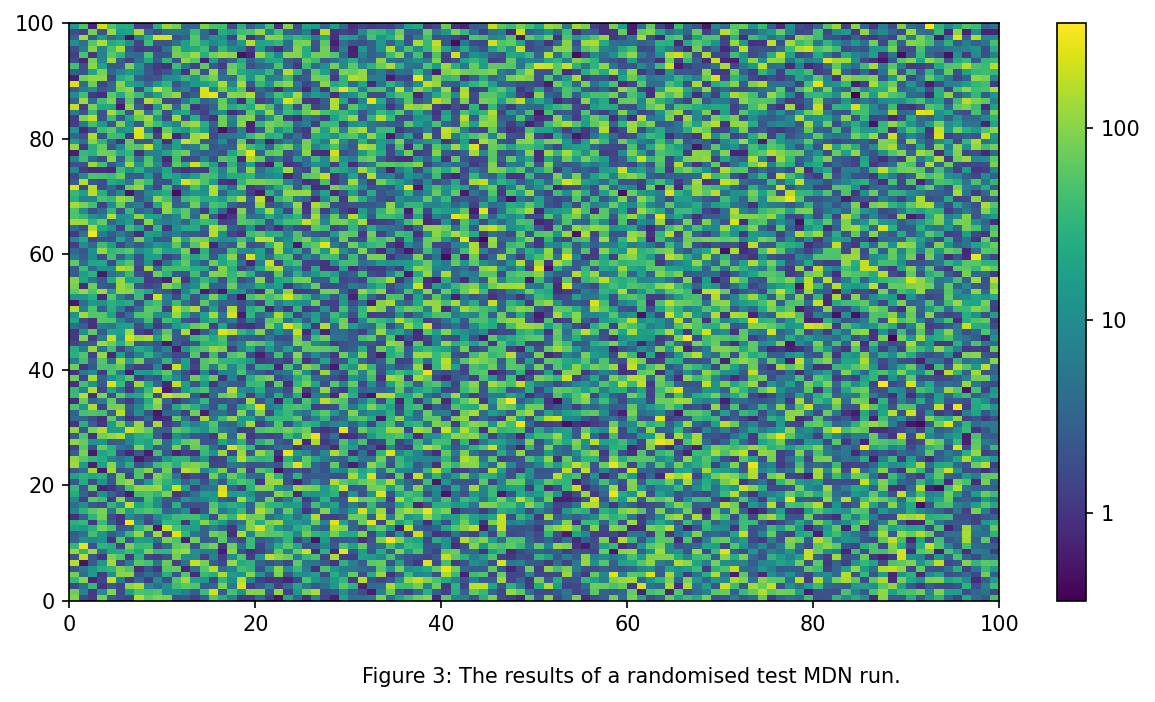

In [8]:
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
plt.pcolormesh(np.log10(chlor_a))
cbar = plt.colorbar(ticks=[-1, 0, 1, 2])
cbar.ax.set_yticklabels([10**x for x in [-1, 0, 1, 2]])

fig1.text(.5, 0.00, r'Figure 3: The results of a randomised test MDN run.',\
          ha='center', fontsize=10)
plt.show()

## 4 - Running the MDN model <a id='model_run'></a>

### Standard experiments

Now we have set up our experiments and tested the model, we can run it over our scenes. The next two boxes below will retrieve our R$_{rs}$ data from our product and launch the MDN model for experiment 1 and 2.

In [9]:
Rrs, lon_S3, lat_S3 = osf.read_S3_L2_standard(Experiments['Ex1']['input_prod'],\
                                        Experiments['Ex1']['sensor'],\
                                        Experiments['Ex1']['coords'],\
                                        Experiments['Ex1']['rrs_correct'])
print('Running experiment 1!')
estimates_S3 = image_estimates(Rrs, sensor=Experiments['Ex1']['sensor'])

Closest band for 411: Oa02
Closest band for 442: Oa03
Closest band for 490: Oa04
Closest band for 510: Oa05
Closest band for 560: Oa06
Closest band for 619: Oa07
Closest band for 664: Oa08
Closest band for 681: Oa10
Closest band for 708: Oa11
Closest band for 753: Oa12
Closest band for 778: Oa16
Running experiment 1!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.10s/it]


In [10]:
Rrs, lon_S2, lat_S2 = osf.read_S2_L2_standard(Experiments['Ex2']['input_prod'],\
                                        Experiments['Ex2']['sensor'],\
                                        Experiments['Ex2']['coords'],\
                                        Experiments['Ex2']['rrs_correct'])
print('Running experiment 2!')
estimates_S2 = image_estimates(Rrs, sensor=Experiments['Ex2']['sensor'])

Closest band for 443: B01
Closest band for 490: B02
Closest band for 560: B03
Closest band for 665: B04
Closest band for 705: B05
Closest band for 740: B06
Closest band for 783: B07
Running experiment 2!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


Now that we have our output, lets compare the results. The box below will plot our OLCI and MSI chlorophyll estimates side by side.

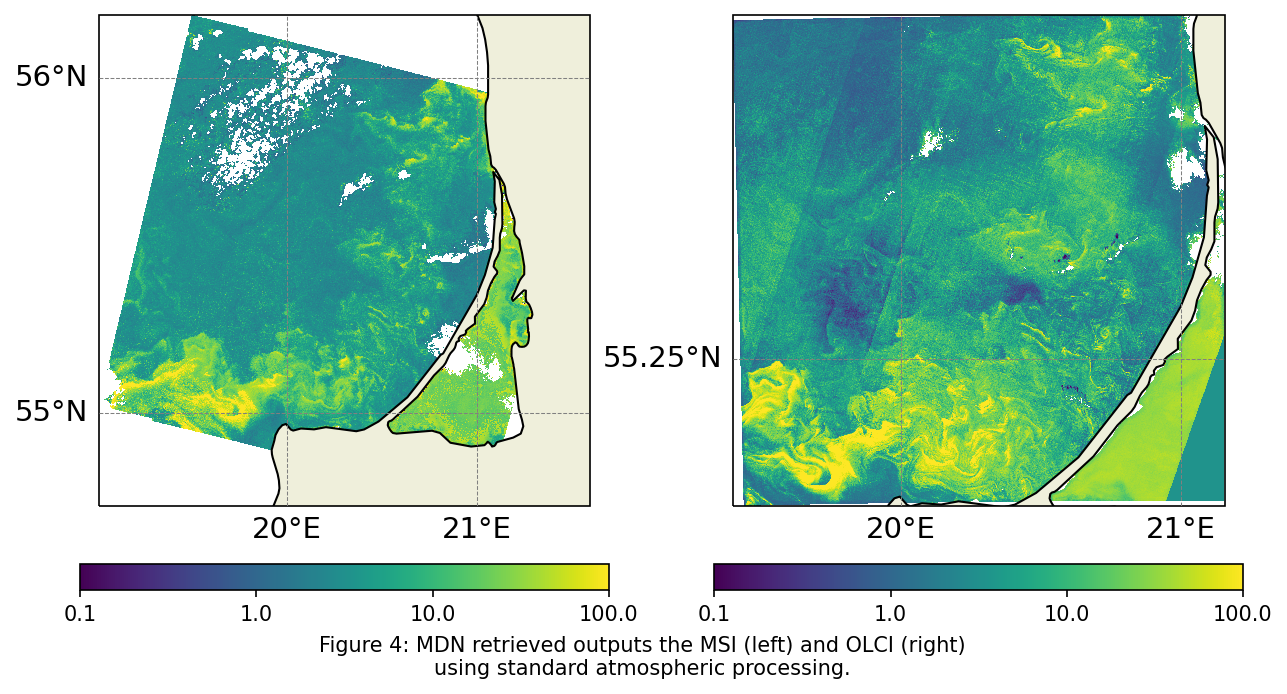

In [11]:
# Plot our output
# get our land mask from NaturalEarth
ticks = [-1,0,1,2]
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                    edgecolor='k', facecolor=cfeature.COLORS['land'])
# intitialise our figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make an axis
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon_S3, lat_S3, np.log10(estimates_S3[0]))
p1.set_clim(min(ticks), max(ticks))
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.ax.set_xticklabels(10**np.asarray([-1,0,1,2]).astype(float), fontsize=10)
m.coastlines(resolution=land_resolution, color='black', linewidth=0.25)
m.add_feature(land_poly)

# make an axis
m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon_S2, lat_S2, np.log10(estimates_S2[0]))
p1.set_clim(min(ticks), max(ticks))
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.ax.set_xticklabels(10**np.asarray(ticks).astype(float), fontsize=10)
m.coastlines(resolution=land_resolution, color='black', linewidth=0.25)
m.add_feature(land_poly)

fig1.text(.5, 0.0, r'Figure 4: MDN retrieved outputs the MSI (left) and OLCI (right)'+'\n'+ 
          'using standard atmospheric processing.',\
          ha='center', fontsize=10)

plt.show()

These products are currently on different grids; a 300 m grid for OLCI and a 60 m grid for MSI. To compare the anomaly between them, we need to interpolate the MSI data onto the OLCI grid, as done in the box below.

In [12]:
# anomaly
S2_interp_CHL = griddata((lon_S2.ravel(), lat_S2.ravel()), estimates_S2[0].ravel(),\
                         (lon_S3.ravel(),lat_S3.ravel()), method='nearest').reshape(np.shape(lat_S3))

Now we can plot this anomaly.

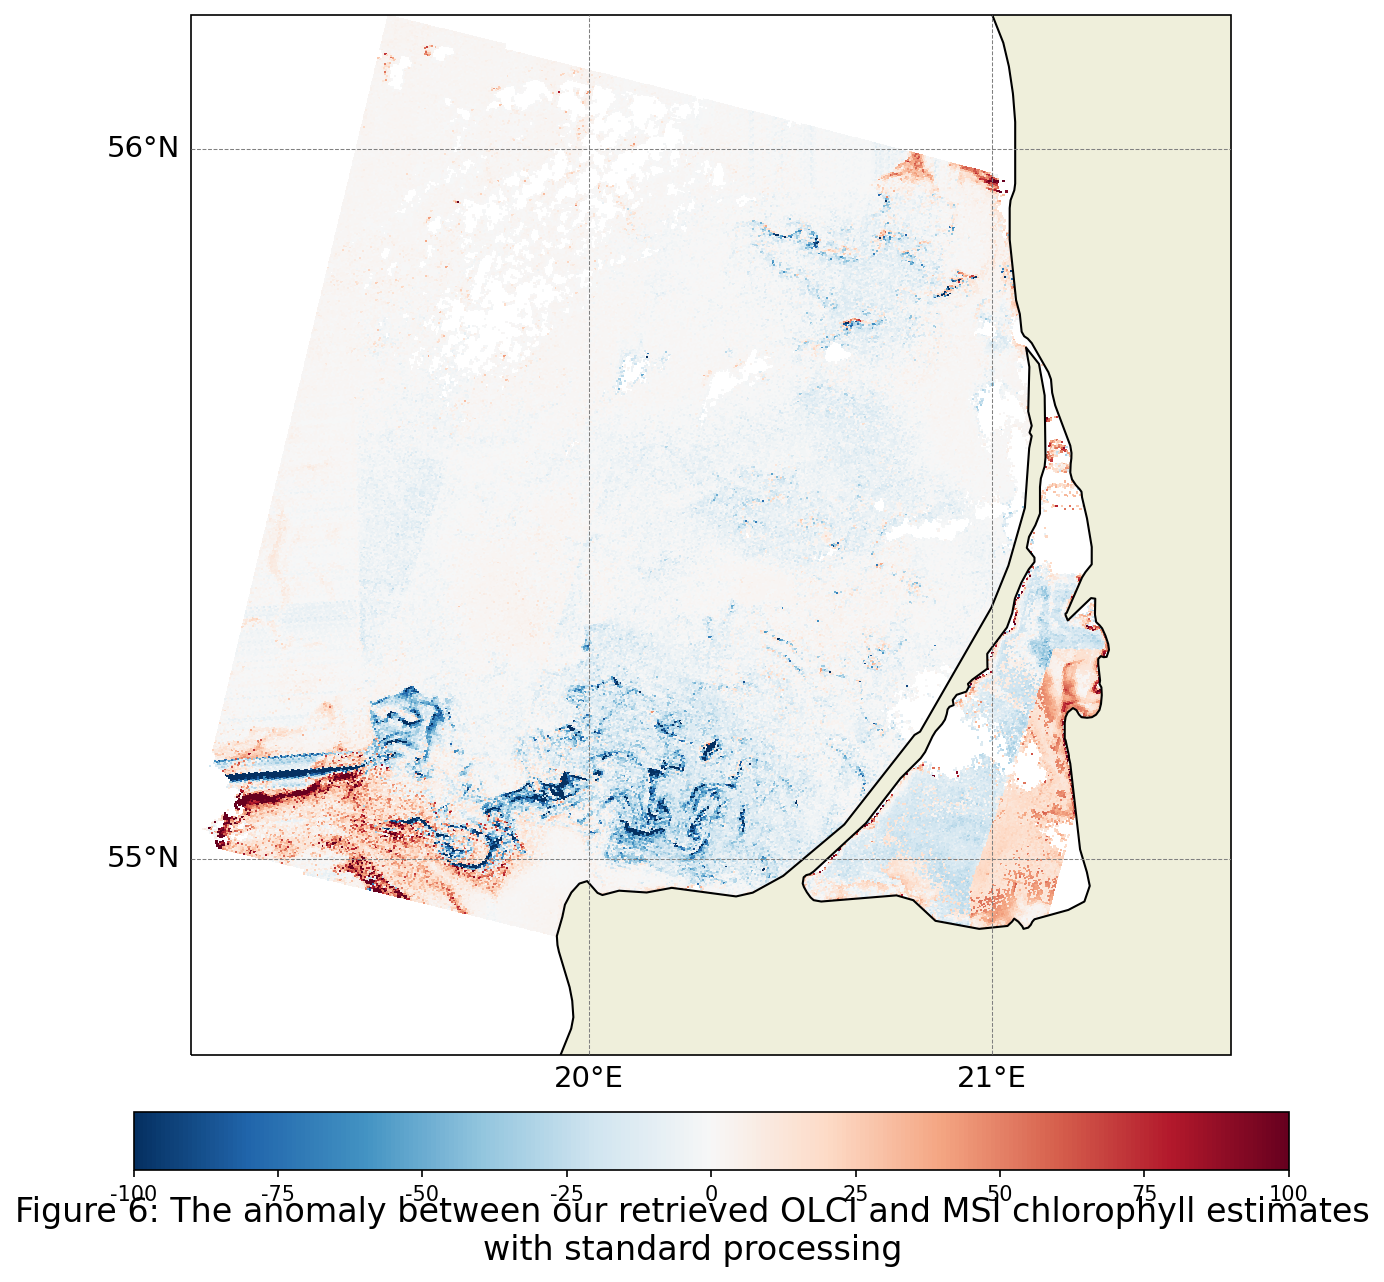

In [13]:
# intitialise our figure
fig1 = plt.figure(figsize=(10, 10), dpi=dpi)

# make an axis
ticks = [-100,-75,-50,-25,0,25,50,75,100]
m = plt.subplot(projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon_S3, lat_S3, estimates_S3[0] - S2_interp_CHL, cmap=plt.cm.RdBu_r)
p1.set_clim(min(ticks), max(ticks))
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.05, ticks=ticks)
cbar.ax.set_xticklabels(ticks, fontsize=10)
m.coastlines(resolution=land_resolution, color='black', linewidth=0.25)
m.add_feature(land_poly)

fig1.text(.5, 0.05, r'Figure 6: The anomaly between our retrieved OLCI and MSI chlorophyll estimates'+'\n'+
          'with standard processing', ha='center', fontsize=16)

plt.show()

Not as "seamless" a retrieval as we had hoped. We still have substantial anomalies between the MSI and OLCI chlorophyll data. However, we should bear in mind that the OLCI and MSI images are from 1-hour apart,and this is easily enough time for the marine environment to change! Lets try again with our Polymer data, which has been treated specifically for the ocean, and see if we do better...

### Polymer experiments

As before, we load our polymer processed data and launch the MDN processor, this time for experiments 3 and 4.

In [14]:
# Pre-process our data ready to run experiment 3
bands, Rrs = get_tile_data(Experiments['Ex3']['input_prod'], Experiments['Ex1']['sensor'], allow_neg=False)
Rrs = Rrs[OLCI_coords[0]:OLCI_coords[1],OLCI_coords[2]:OLCI_coords[3],:]
          
# Make the run
print('Running...')
estimates_S3_poly = image_estimates(Rrs, sensor=Experiments['Ex3']['sensor'])

Running...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.11it/s]


In [15]:
# Pre-process our data ready to run experiment 4
bands, Rrs = get_tile_data(Experiments['Ex4']['input_prod'], Experiments['Ex4']['sensor'], allow_neg=False)

# Make the run
print('Running...')
estimates_S2_poly = image_estimates(Rrs, sensor=Experiments['Ex4']['sensor'])

Running...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


...and again, as before, we need to interpolate the MSI chlorophyll onto the OLCI grid before we compare.

In [16]:
# anomaly
S2_interp_CHL_poly = griddata((lon_S2.ravel(), lat_S2.ravel()), estimates_S2_poly[0].ravel(),\
                         (lon_S3.ravel(),lat_S3.ravel()), method='nearest').reshape(np.shape(lat_S3))

And finally, we plot our anomaly.

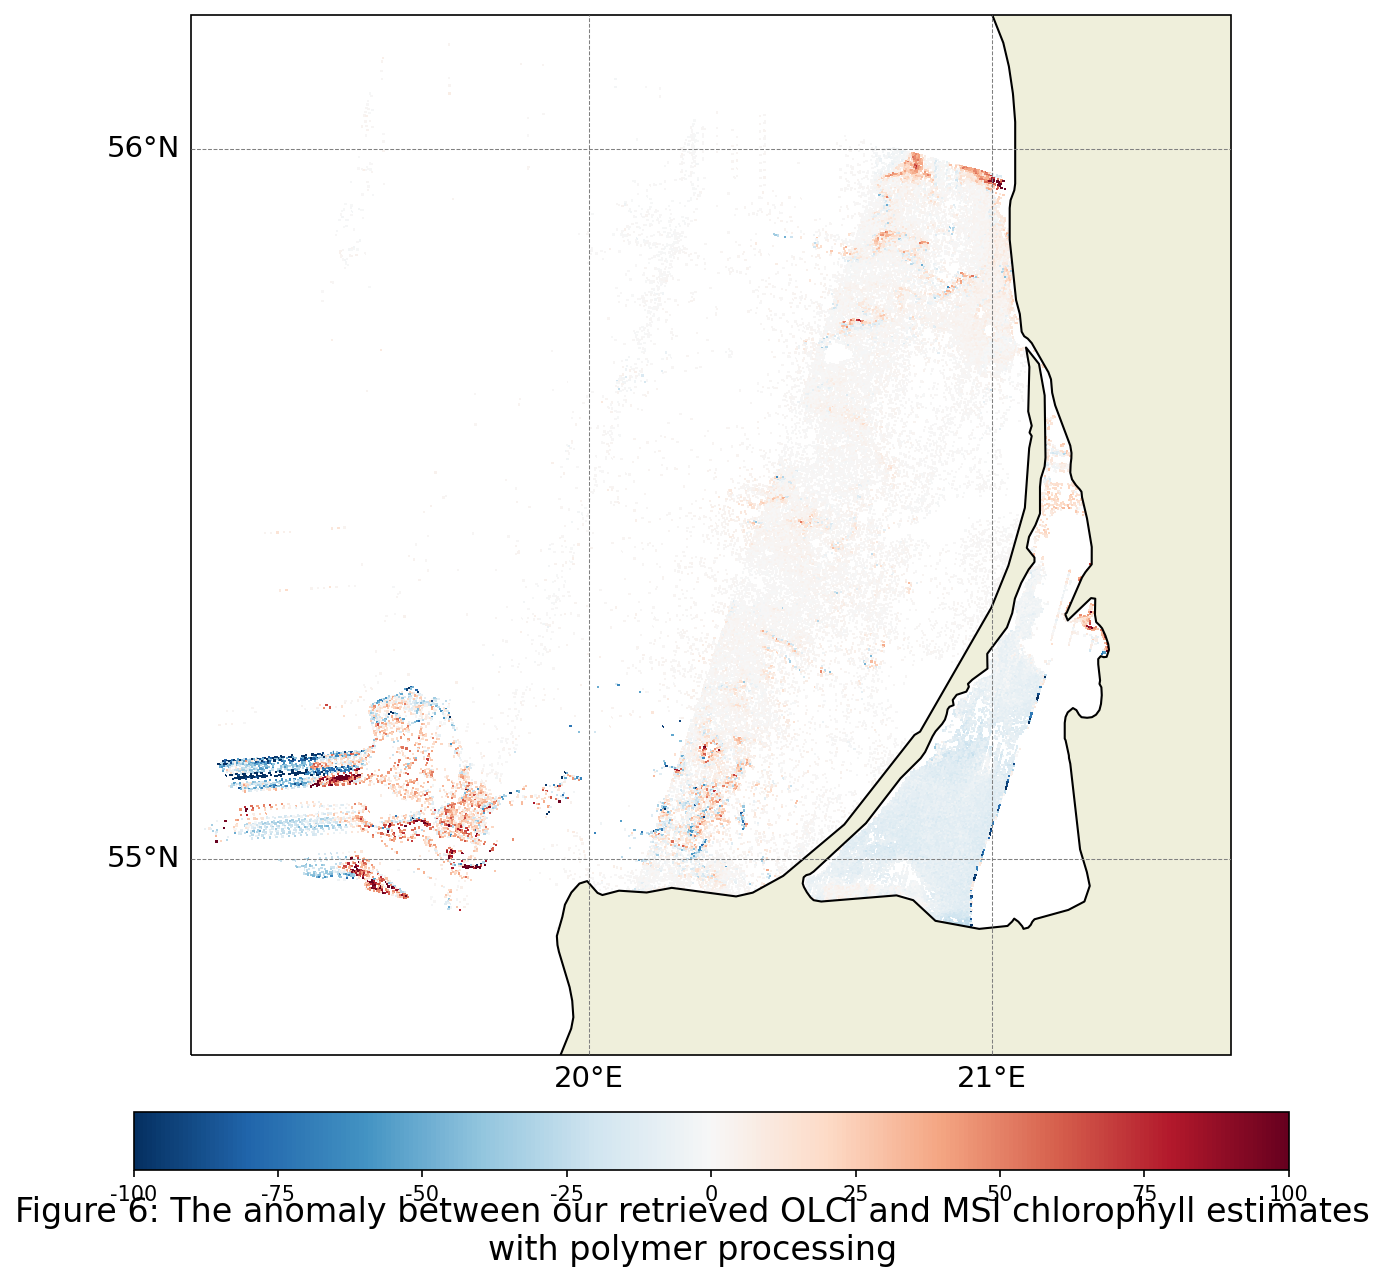

In [17]:
# intitialise our figure
fig1 = plt.figure(figsize=(10, 10), dpi=dpi)

# make an axis
m = plt.subplot(projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon_S3, lat_S3, estimates_S3_poly[0] - S2_interp_CHL_poly, cmap=plt.cm.RdBu_r)
p1.set_clim(min(ticks), max(ticks))
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.05, ticks=ticks)
cbar.ax.set_xticklabels(ticks, fontsize=10)
m.coastlines(resolution=land_resolution, color='black', linewidth=0.25)
m.add_feature(land_poly)

fig1.text(.5, 0.05, r'Figure 6: The anomaly between our retrieved OLCI and MSI chlorophyll estimates'+'\n'+
          'with polymer processing', ha='center', fontsize=16)

plt.show()

We still have some anomalies. However, these are likely due to the changes in the marine environment between the two images (> 1 hour apart), but our estimates are much more consistent than before! This highlights the necessity of ensuring that you have properly treated your input data. More often than not, machine learning methods will return an answer regardless, so you need to be sure that your answer is based on the best possible information.

## 5 - Conclusions <a id='conclusions'></a>

Our coastal oceans are complex. To give us the best possible ocean picture of their nature and variability from Earth Observation, we need to take advantage of the capability of multiple sensors. Machine learning approaches, such as `mixture density networks`, show great promise in helping us to combine data from these disparate sources, and so help us to better understand and monitor the processes that govern the highly dynamic regions near our shore, where most of us engage with the ocean.

For further examples of how Copernicus satellite data is used in water quality applications see [here](https://www.copernicus.eu/en/website-search?search_api_fulltext=water+quality).

<hr>

<img src='../../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
